# Colours & Images across cultures
## Analysing the Unsplash image data

Link to GitHub: [https://github.com/HannahKnights/everything_counts-a2](https://github.com/HannahKnights/everything_counts-a2)

### Introduction

[Unsplash](https://unsplash.com/) (owned by [Getty images](https://www.gettyimages.co.uk/) since 2021) is a stock image provider in which users can upload and download images. They have published some of their dataset which includes data about:

- **Photos** *(25,000)* - URL, dimensions, EXIF information - including location where available
- **Colours** *(245,676)* - images have been categorised to identify the dominant colours
- **Conversions** *(12,166,088)* - number of downloads of the images, what keyword was used to find them and where the download took place

The data sources are a subset of the entire dataset on Unsplash, but do include a large amount of records. There are various things that could be attempted to unpack from this dataset, I will be assessing the relationship between location and colour.

Data downloaded on  November 2024 from [Kaggle](https://www.kaggle.com/datasets/anandaramg/unsplash-image-download-data/data)

*Note on AI usage: ChatGPT was used on this assigment, to give suggestions and direction on visualisation (specifically colours and mapping) and some pointers on code snippets and python libraries at various points (code not used verbatum). ChatGPT was not used on the subject of the data, the hypothesis or the interpretation.*

In [1]:
# import relevant libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image
import calendar
%config InlineBackend.figure_format = 'retina'

# load data into the dataframe
# IMPORTANT! note the conversions.csv file was too large to be uploaded to GitHub, even when the full dataset was reduced to releavnt rows and columns
# and also once zipped. Therefore if you want to run this code fully, then you will need to download `conversions.csv` from the following URL 
# directly from Kaggle https://www.kaggle.com/datasets/anandaramg/unsplash-image-download-data/data
colours_df = pd.read_csv('colors.csv')
print('downloaded colours: %s' % colours_df.shape[0])
conversions_df = pd.read_csv('conversions.csv')
print('downloaded conversions: %s' % conversions_df.shape[0])
photos_df = pd.read_csv('photos.csv')
print('downloaded photos: %s' % photos_df.shape[0])
# data downloaded from https://www.kaggle.com/datasets/anandaramg/unsplash-image-download-data/data (November 2024)


downloaded colours: 245676
downloaded conversions: 12166088
downloaded photos: 25000


## Data overview

Before exploring hypothesis about the data I will do a high-level exploration of it, to get to grips with what it tells us and what can be done with it. 

In [2]:
# Create dataframe which includes colour and geographic information e.g. the longitude and latitutude and countries that the photos were taken
# The 'photo_id' field is the index between the colours_df and the photos_df datasets 
# There is a one to many relationship here which we need to reflect in how we merge these tables e.g. there may be many colour rows for each photo

# we only want to use colours that have longitude / latitude fields as we will analyse location
# so first let's filter that data set by those fields

photos_df = photos_df[(photos_df['photo_location_latitude'].notnull()) & (photos_df['photo_location_longitude'].notnull())]
photocolours_df = colours_df.merge(photos_df, how='inner', on='photo_id')
# the merged dataset is quite large (70403, 38) so we shall remove columns which will not be necessary to our analysis
photocolours_df = photocolours_df.drop(columns=[
    'photo_width','photo_height', 'photo_aspect_ratio',
    'photo_description', 'photographer_username', 'photographer_first_name',
    'photographer_last_name', 'exif_camera_make', 'exif_camera_model',
    'exif_iso', 'exif_aperture_value', 'exif_focal_length',
    'exif_exposure_time', 'photo_location_name', 'photo_location_city',
    'ai_description', 'ai_primary_landmark_name','ai_primary_landmark_latitude', 'ai_primary_landmark_longitude',
    'ai_primary_landmark_confidence', 'blur_hash'
])

# Lastly, the conversion dataframe is very large, let's reduce it to only the data for the photo_ids that we are looking at
pd.Series(photos_df['photo_id'])
conversions_df = conversions_df[conversions_df['photo_id'].isin(pd.Series(photos_df['photo_id']))]

In [3]:
# Colour, Conversions and Photo tables in numbers
colour_data = [
    '|Numbe of unique CSS colours|%s|' % photocolours_df['keyword'].nunique(),
    '|Numbe of unique RGB colours|%s|' % len(photocolours_df.groupby(['red','green','blue']).size()),
    '|Mean (R, G, B)|(%s,%s,%s)|' % (
        int(photocolours_df['red'].describe()['mean']),
        int(photocolours_df['green'].describe()['mean']),
        int(photocolours_df['blue'].describe()['mean'])
    )
]
display(Markdown("""
**`Colour` data**
| Description | Value |
| --- | --- | 
%s""" % (
    '\n'.join(colour_data)   
)))

conversion_data = [
    '|Total downloads|%s|' % len(conversions_df),
    '|Unique number of images downloaded|%s|' % conversions_df['photo_id'].nunique(),
    '|Unique number of keywords|%s|' % conversions_df['keyword'].nunique(),
    '|Number of countries|%s|' % conversions_df['conversion_country'].nunique(),
]
display(Markdown("""
**`Conversion` data**
| Description | Value |
| --- | --- | 
%s""" % (
    '\n'.join(conversion_data)   
)))

photo_data = [
    '|Number of photos|%s|' % len(photos_df),
    '|Number of countries|%s|' % photos_df['photo_location_country'].nunique(),
    '|Mean number of downloads|%s|' % photos_df['stats_downloads'].describe()['mean'],
    '|Mean number of views|%s|' % photos_df['stats_views'].describe()['mean'],
]
display(Markdown("""
**`Photo` data**
| Description | Value |
| --- | --- | 
%s""" % (
    '\n'.join(photo_data)   
)))



**`Colour` data**
| Description | Value |
| --- | --- | 
|Numbe of unique CSS colours|139|
|Numbe of unique RGB colours|64780|
|Mean (R, G, B)|(124,118,110)|


**`Conversion` data**
| Description | Value |
| --- | --- | 
|Total downloads|4735855|
|Unique number of images downloaded|7116|
|Unique number of keywords|282944|
|Number of countries|233|


**`Photo` data**
| Description | Value |
| --- | --- | 
|Number of photos|7144|
|Number of countries|333|
|Mean number of downloads|14797.816209406496|
|Mean number of views|3934343.1319988803|

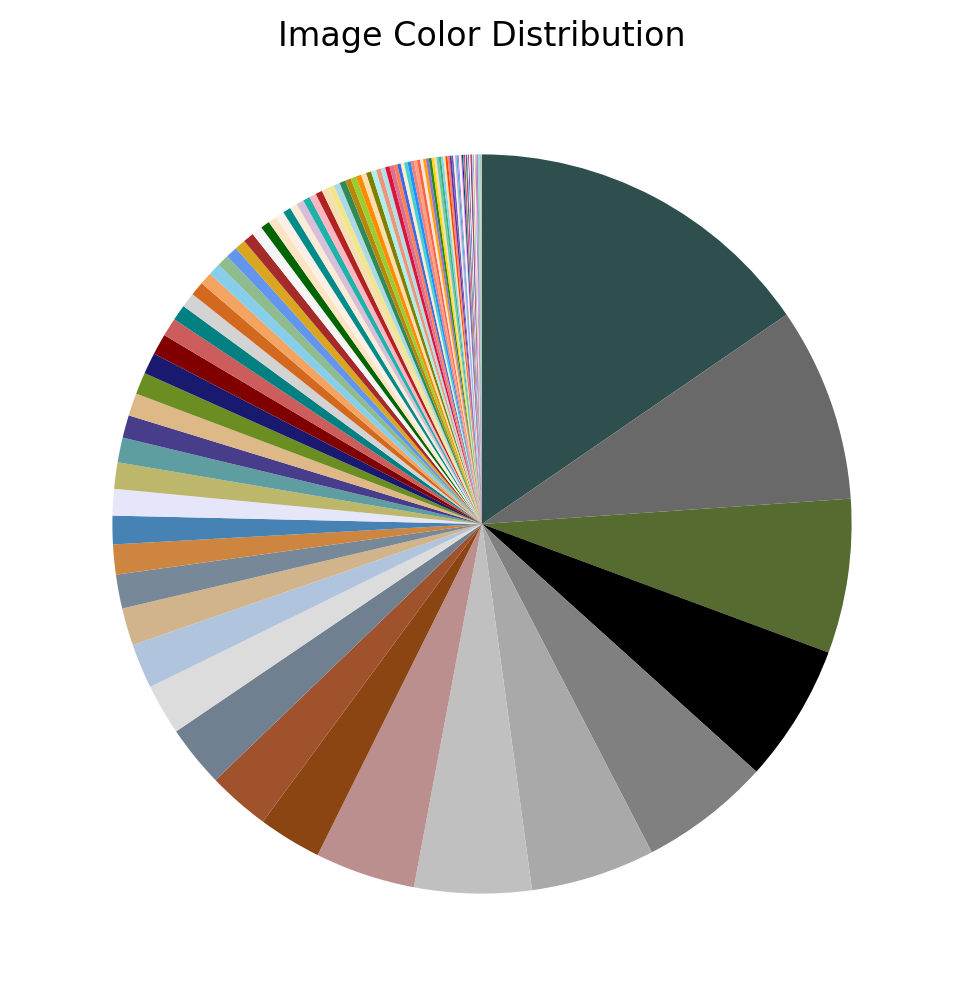

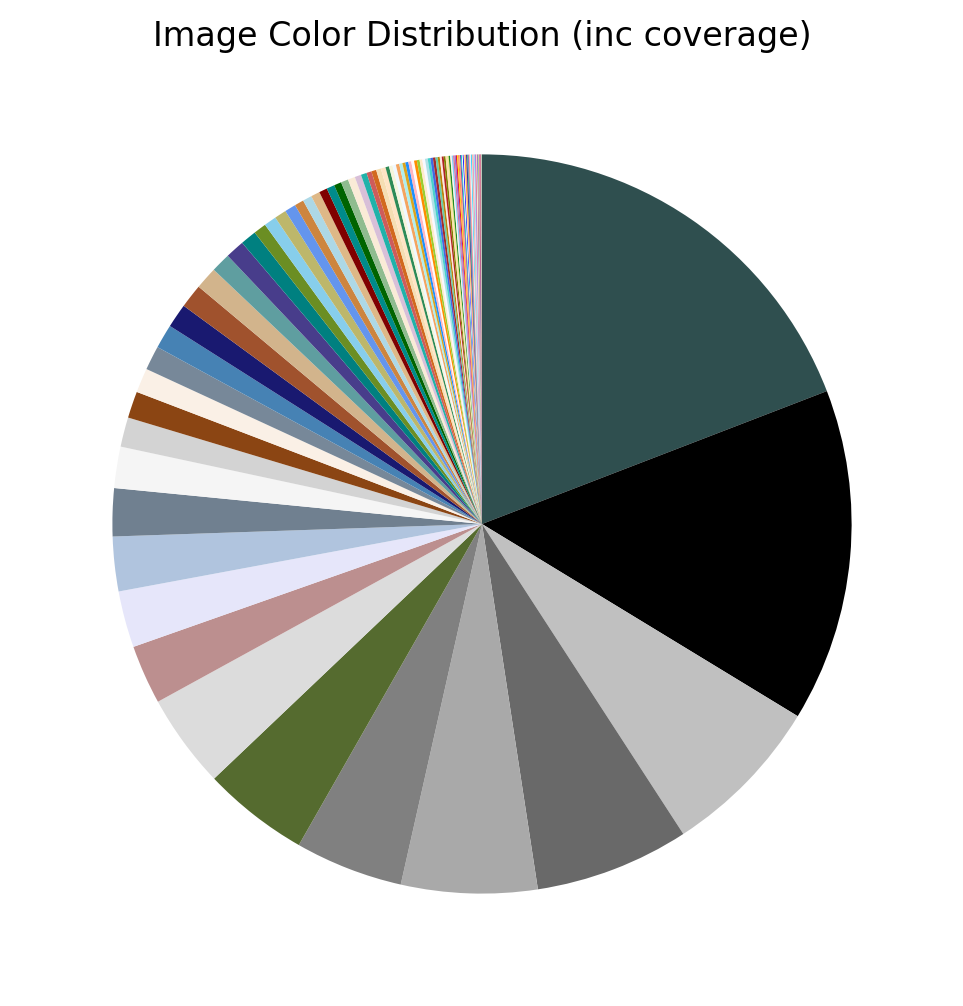

In [4]:
# Let's do an initial mapping of all the CSS colour data
colour_series = pd.Series(photocolours_df['keyword'])

# We will plot the distribition of the colours on a "colour wheel" (pie chart), we will do 2 versions:
# - Take a simple assessment of the data looking at the frequency of colours overall
# - Factoring in the `ai_coverage` that calculates the amount of the image that contains the colour, to compare the difference
distribution_sets = {
    'Image Color Distribution' : colour_series.value_counts().reset_index(name='Frequency'),
    'Image Color Distribution (inc coverage)' : photocolours_df[['keyword','ai_coverage']].groupby('keyword', as_index=False).sum().sort_values('ai_coverage', ascending = False)
}

for this_set in distribution_sets:
    colour_counts = distribution_sets.get(this_set)#colour_series.value_counts().reset_index(name='Frequency')
    colour_counts.columns = ['Colour', 'Frequency']

    # Plot the data
    plt.figure(figsize=(6, 6))
    plt.pie(colour_counts['Frequency'], colors=colour_counts['Colour'], startangle=90, counterclock=False)
    plt.title(this_set)
    plt.show()

# There's a column in colours for the `ai_coverage` that calculates the amount of the image that contains the colour
# Let's compare how this changes the distribution of the colours across the dataset
#color_counts = photocolours_df[['keyword','ai_coverage']].groupby('keyword', as_index=False).sum().sort_values('ai_coverage', ascending = False)


The dominant colour profiles in both sets are similar (cool colours, grayscale leaning in tone), but certainly display a difference in distribution. This highlights some potential dangers of the datasets that we will need to be aware of as we continue the analysis:

- There may be various ways to interpret this information, we are abstracting the raw data and using estimations. This is not a pixel by pixel analysis of colour
- The clour spectrum is large and we need to add in additional categroisations of "colour" in e.g. saturation, hue, "temperature" to get more collated information

It will be useful to visualise the spread of the data, to understand and be aware of the geographical bias within it.

In [41]:
import plotly.express as px
fig = px.scatter_geo(photos_df, 
    lat = "photo_location_latitude",
    lon = "photo_location_longitude",
    projection="natural earth",
    title = "Map of the upload location of all photos in the dataset"
)
fig.show()

We can clearly see from the map that there is a North American and European bias to the data (shown by the colour saturated area). This will limit the confidence we can make any "universal" assertions.

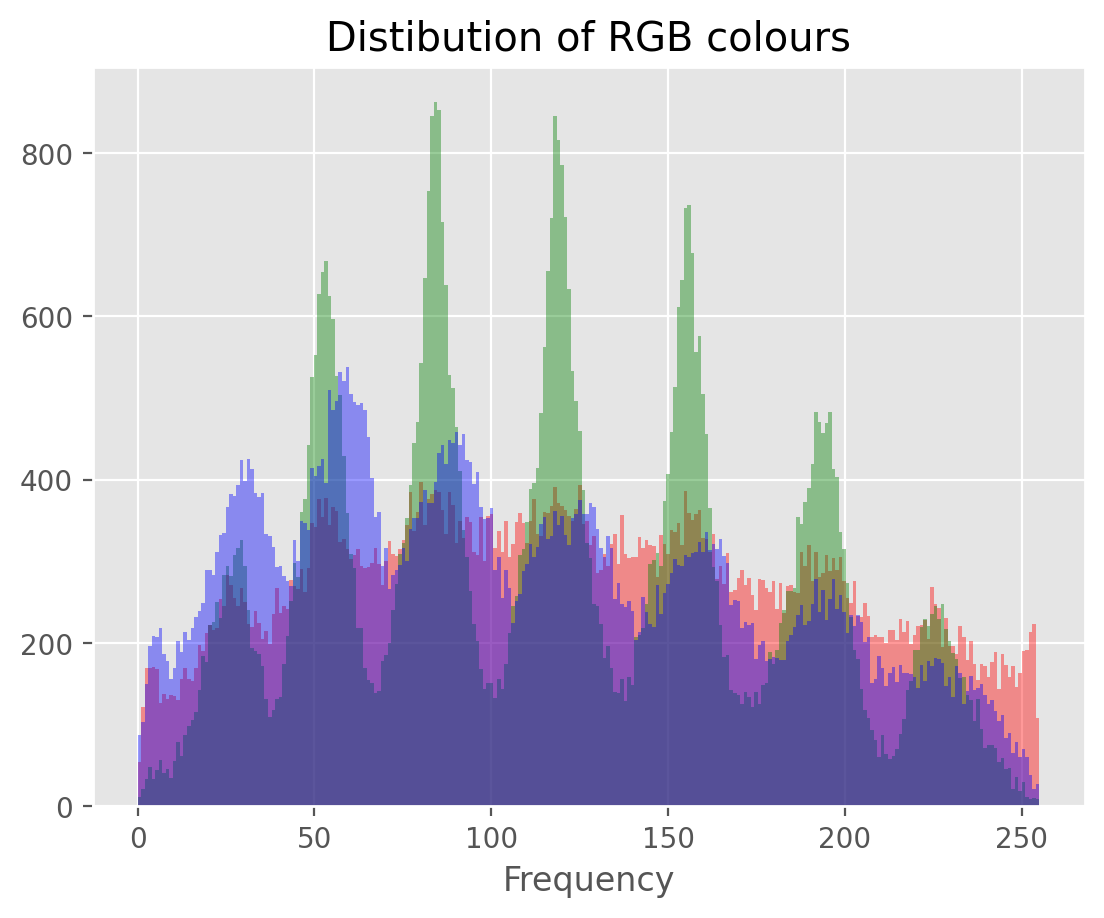

In [5]:
plt.style.use('ggplot')
plt.hist(photocolours_df['red'], bins = 256, alpha = 0.4, color='red')
plt.hist(photocolours_df['green'], bins = 256, alpha = 0.4, color='green')
plt.hist(photocolours_df['blue'], bins = 256, alpha = 0.4, color='blue')
plt.title('Distibution of RGB colours')
plt.xlabel('RGB value')
plt.xlabel('Frequency')
plt.show()

The historgram above shows the distribution of RGB colours across the dataset. Looking at the coverage of this dataset and the amount of variables, it seems like it might cause some difficulties to analyse in the circumstance. The plot is interesting and the spikes which are most clearly visible in the 'blue' and 'green' are an interesting pattern of distribution. I am time limited in how I'll be able to interpret this, so will look at the 'keyword' field which reflects CSS colour variables when looking at colours going forward.

In [47]:
#  Count occurrences of each keyword
keywords_series = pd.Series(conversions_df['keyword'])
keyword_counts = keywords_series.value_counts()

# Display 10 most frequent
keyword_data = []
for kw, count in keyword_counts.iloc[:10].items():
    keyword_data.append(
        '|%s|%s|' % (kw, count)   
    )
display(Markdown("""
**10 most popular `keyword` search for downloaded image**
| Keyword | Count |
| --- | --- | 
%s""" % (
    '\n'.join(keyword_data)   
)))


**10 most popular `keyword` search for downloaded image**
| Keyword | Count |
| --- | --- | 
|nature|170338|
|sea|105676|
|sky|104078|
|ocean|92900|
|mountain|89599|
|flowers|83142|
|mountains|75278|
|beach|73276|
|natural|56010|
|moon|52008|

The `conversions` dataframe is very large, looking at the most popular results will give some guidance about what to use for hypothesis testing

# Image choices and geography
## Does country affect preferences about image subject?

In a playful data analysis of Google's [Quick, Draw!](https://quickdraw.withgoogle.com/) game, the author analysed the data suggest that there was a relationship between the way that the global partipants drew a circle and their culture (country, language, writing direction). Within this dataset I wanted to explore whether there is any statistically significant relationship between a choice of image and country.

There are reviews which show relationship between colour and geogrpahic proximity (Jonauskaite et al, 2022), here we will extrapolate this out more broadly to imagary.

Approach:
- The `conversions` table contains a log of downloaded images, based upon searched for keywords, within this data is a country field which reflects the country where the 'download' action takes place
- We will use the data above to look for any relationships between country and image e.g. **when searching for 'nature' images is there a relationship between the image chosen and the country the user is in?**


Some notes on the limitations, biases and unknowns within the dataset: 
- There are many unknowns in the data including:
    - How are the users searching for keywords, are they suggested search terms or are they inputting them?
    - Are the search results returned and ordered consistantly for all users?
    - Does Unsplash change the results of the image search based on the user's country already
- The most popular search terms and those we will use are all in English, this again reduces the variance in the diversity of our datset
- The 'country' data does not necessarily reflect where the user is from, just where the action took place, we know nothing about the user

**Null Hypothesis = The users country has no affect on the image that the user downloaded**

In [19]:
# As the dataset is so large, I am going to do this hypothesis on the most commonly searched term 'nature'
nature_df = conversions_df[conversions_df['keyword'] == 'nature']

# It's a large dataset so should give a good variation of data to work from
nature_data = [
    '|Number of rows|%s|' % nature_df['conversion_country'].describe()['count'],
    '|Number of unique countries|%s|' % nature_df['conversion_country'].nunique(),
    '|Number of unique photos|%s|' % nature_df['photo_id'].nunique()
]
display(Markdown("""
**`Conversions > Nature` data**
| Description | Value |
| --- | --- | 
%s""" % (
    '\n'.join(nature_data)   
)))


**`Conversions > Nature` data**
| Description | Value |
| --- | --- | 
|Number of rows|170075|
|Number of unique countries|209|
|Number of unique photos|1219|

In [48]:
import scipy.stats as stats

# We will be dealing with 2 sets of categorical data
# - Country (`conversion_country`)
# - Photo id (`photo_id`)
# Therefore we will perform a Chi-square test to understand the relationship (this is not the only test we could chose but is most appropriate for categorical data)

contingency_table = pd.crosstab(nature_df['conversion_country'], nature_df['photo_id'])
# Run the Chi-square test and return the restuls
chi2, p, dof, expected_freq = stats.chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")

data = [
    '|Chi-squared|%s|' % chi2,
    '|P-value|%s|' % p,
    '|DOF|%s|' % dof
]
display(Markdown("""
**`Country > Downloaded photo` Chi-square results**
| Measure | Value |
| --- | --- | 
%s""" % (
    '\n'.join(data)   
)))

Chi-squared statistic: 250966.7270105713
P-value: 0.9995948852571269



**`Country > Downloaded photo` Chi-square results**
| Measure | Value |
| --- | --- | 
|Chi-squared|250966.7270105713|
|P-value|0.9995948852571269|
|DOF|253344|

**Interpretation**

This is a large p-value of much greater than `0.05` therefore we *cannot* reject the null hypothesis that there is no affect on the image a user downloads based upon the continent they do this from. 

It may be interesting however to zoom out a level and look at the same data from the perspective on continent. This broader categorisation will better account for the reality of culture and language being shared across borders, by neighbours and wider regions.


In [25]:
import pycountry_convert as pc

# It will be useful to have continent information as well as country, this may be a better grouping to understand behaviours 
# to do this we will use a function in the pycounty_convert library. Having tried this already I found there to be some values
# which couldn't be converted; I'm going to deal with those exceptions below which requires removing NaN values and creating an
# additional map of country to continent codes, for countries that were missing from the Python library

# firstly there are some NaN values for country, let's remove those
nature_df.dropna(subset=['conversion_country'], inplace=True)

def get_continent_from_country(country):
    countries_to_map = {
        'SX' : 'NA',
        'TL': 'AS',
        'AQ' : 'AN',
        'VA' : 'EU'
    }
    if country in countries_to_map:
        return countries_to_map.get(country)
    else:
        return pc.country_alpha2_to_continent_code(country)

nature_df['conversion_continent_code'] = nature_df['conversion_country'].apply(get_continent_from_country)

# let's add the number of unique continents to the data from before
nature_data.append(
    '|Number of unique continents|%s|' % nature_df['conversion_continent_code'].nunique(),
)
display(Markdown("""
**`Conversions > Nature` data**
| Description | Value |
| --- | --- | 
%s""" % (
    '\n'.join(nature_data)   
)))



**`Conversions > Nature` data**
| Description | Value |
| --- | --- | 
|Number of rows|170075|
|Number of unique countries|209|
|Number of unique photos|1219|
|Number of unique continents|6|

**Null Hypothesis = The users continent has no affect on the image that the user downloaded**


In [27]:
contingency_table = pd.crosstab(nature_df['conversion_continent_code'], nature_df['photo_id'])
# Run the Chi-square test and return the restuls
chi2, p, dof, expected_freq = stats.chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")

data = [
    '|Chi-squared|%s|' % chi2,
    '|P-value|%s|' % p,
    '|DOF|%s|' % dof
]
display(Markdown("""
**`Continent > Downloaded photo` Chi-square results**
| Measure | Value |
| --- | --- | 
%s""" % (
    '\n'.join(data)   
)))

Chi-squared statistic: 11359.25810240704
P-value: 0.0



**`Continent > Downloaded photo` Chi-square results**
| Measure | Value |
| --- | --- | 
|Chi-squared|11359.25810240704|
|P-value|0.0|
|DOF|6090|

**Interpretation**

This gives us a very different result, the p-value is smaller than `0.05`, so small it can't be represented here. Therefore we are able to suggest that there is a statistical significance here and that we *can* reject the null hypothesis that there is no affect on the image a user downloads based upon the continent they do this from. 

There is a wealth of more analytical and extensive reviews you can do from this dataset. Having done some high-level analysis and made some intital hypothesis, it's giving me much reflection on what a deeper dive would look like. The dataset is imperfect and the colour data poses some challenges for review, but there's certainly more to explore here.

## References

- Jonauskaite, Domicele & Abu-Akel, Ahmad & Dael, Nele & Oberfeld, Daniel & Abdel-Khalek, Ahmed & Al-rasheed, Abdulrahman & Antonietti, Jean-Philippe & Bogushevskaya, Victoria & Chamseddine, Amer & Chkonia, Eka & Corona, Violeta & Fonseca-Pedrero, Eduardo & Griber, Yulia & Grimshaw, Gina & Hasan, Aya & Jelena, Havelka & Hirnstein, Marco & Karlsson, Bodil & Laurent, Eric & Mohr, Christine. (2020). Universal Patterns in Color-Emotion Associations Are Further Shaped by Linguistic and Geographic Proximity. Psychological Science. 31. 1245-1260. 10.1177/0956797620948810. 